In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon
import pandas as pd
from scipy import stats

# ================================================================
#  CLEAN, SIMPLIFIED GROUPED BOXPLOTS WITH OPTIONAL SWARM PLOTTING
# ================================================================
def grouped_boxplot(
    groups,
    regions,
    params=None,
    pval_func=None
):
    """
    Parameters
    ----------
    groups : list of tuples
        Each tuple contains arrays. Example:
            [(main1_group1, main2_group1, null1_group1, null2_group1),
             (main1_group2, main2_group2, ...), ...]
    regions : list[str]
        X-axis labels.
    params : dict
        Appearance and behavior settings.
    pval_func : callable
        p = pval_func(data1, data2)
    """

    # ----------------------------
    # Defaults
    # ----------------------------
    default_params = dict(
        figsize=(8, 5),
        title="Grouped Boxplots",
        ylabel="Value",

        # main data (usually 2: GCaMP False / True)
        main_colors=["skyblue", "salmon"],
        main_labels=["GCaMP=False", "GCaMP=True"],
        box_width=0.18,

        # null model
        null_colors=["lightgrey", "darkgrey", "silver"],
        null_labels=["Null 1", "Null 2", "Null 3"],
        null_box_width=0.12,

        # position structure
        group_spacing=1.5,
        item_spacing=0.25,

        # options
        single_box=False,     # <---- NEW FEATURE: only show ONE box per group
        swarm=False,          # <---- NEW: jittered points on top
        jitter=0.08,
        jitter_outliers=False,  # <---- NEW: keep outliers centered on the boxplot outlier circles

        # p-values
        pval_indices=(0, 1),
        pval_fontsize=10,
        pval_offset=0.06,

        # axis
        y0_line=True,
        display_legend=True
    )
    if params:
        default_params.update(params)
    p = default_params

    # -----------------------------------
    # Compute positions + color lists
    # -----------------------------------
    fig, ax = plt.subplots(figsize=p["figsize"])

    plot_data = []
    positions = []
    widths = []
    colors = []

    pos = 1
    for g in groups:

        # Reduce to ONE dataset if requested
        if p["single_box"]:
            g = (np.concatenate([arr for arr in g if len(arr) > 0]),)

        n_main = min(len(g), len(p["main_colors"]))
        n_null = len(g) - n_main

        # main data
        for i in range(n_main):
            plot_data.append(g[i])
            positions.append(pos + i * p["item_spacing"])
            widths.append(p["box_width"])
            colors.append(p["main_colors"][i])

        # null models
        for j in range(n_null):
            plot_data.append(g[n_main + j])
            positions.append(pos + (n_main + j) * p["item_spacing"])
            widths.append(p["null_box_width"])
            colors.append(p["null_colors"][j % len(p["null_colors"])])

        pos += (n_main + n_null) * p["item_spacing"] + p["group_spacing"]

    # -----------------------------------
    # Plot boxplots
    # -----------------------------------
    bp = ax.boxplot(
        plot_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        showfliers=True,           # important for outlier control
        flierprops=dict(marker='o', markersize=6, linestyle='none', markeredgecolor='black'),
        medianprops=dict(color='black'),
        boxprops=dict(linewidth=1.4, color='black'),
        whiskerprops=dict(linewidth=1.4, color='black'),
        capprops=dict(linewidth=1.4, color='black')
    )

    # set fill colors
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)

    # -----------------------------------
    # Add jittered swarm points (optional)
    # -----------------------------------
    if p["swarm"]:
        for data, x0 in zip(plot_data, positions):
            if len(data) == 0:
                continue

            # identify outliers from boxplot stats
            stats = cacl_box_stats(data)
            outliers = (data < stats["fliers_low"]) | (data > stats["fliers_high"])

            # jitter for normal points
            jitter_x = x0 + (np.random.rand(len(data)) - 0.5) * 2 * p["jitter"]

            # no-jitter for outliers unless requested
            if not p["jitter_outliers"]:
                jitter_x[outliers] = x0

            ax.scatter(
                jitter_x, data,
                color="black", s=12, alpha=0.7, zorder=3
            )

    # -----------------------------------
    # Draw y=0 line
    # -----------------------------------
    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linewidth=1, linestyle="--")

    # -----------------------------------
    # X-ticks at group centers
    # -----------------------------------
    ticks = []
    pos_idx = 0
    for g in groups:
        n = 1 if p["single_box"] else len(g)
        group_positions = positions[pos_idx:pos_idx+n]
        ticks.append(np.mean(group_positions))
        pos_idx += n

    ax.set_xticks(ticks)
    ax.set_xticklabels(regions)

    # -----------------------------------
    # p-values per group
    # -----------------------------------
    if pval_func:
        for i, g in enumerate(groups):

            if p["single_box"]:
                continue  # no comparison possible

            i1, i2 = p["pval_indices"]
            if len(g) <= max(i1, i2):
                continue

            try:
                pval = pval_func(g[i1], g[i2])
            except Exception:
                pval = np.nan

            ymax = max(np.nanmax(arr) if len(arr) else 0 for arr in g)
            ytxt = ymax * (1 + p["pval_offset"])
            ax.text(ticks[i], ytxt, f"p={pval:.3g}", ha="center",
                    fontsize=p["pval_fontsize"])

    # -----------------------------------
    # Legend
    # -----------------------------------
    handles = []
    if not p["single_box"]:
        for col, lab in zip(p["main_colors"], p["main_labels"]):
            handles.append(plt.Line2D([0], [0], color=col, lw=8, label=lab))

        # include nulls only if they exist
        if any(len(g) > len(p["main_colors"]) for g in groups):
            for col, lab in zip(p["null_colors"], p["null_labels"]):
                handles.append(plt.Line2D([0], [0], color=col, lw=8, label=lab))

        if params["display_legend"]:
            ax.legend(handles=handles, title="Conditions")

    # labels
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])
    fig.tight_layout()

    return fig, ax


# -------------------------
# Helper: Boxplot stats
# -------------------------
def cacl_box_stats(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return dict(fliers_low=low, fliers_high=high)
    


# ================================================================
#  SIMPLE FRONT-END: LOAD CSVs AND FEED TO grouped_boxplot()
# ================================================================
def plot_csv_groups(
    filenames,
    regions,
    column,
    null_filenames=None,
    params=None,
    pval_func=None,
    only_gcamp=False  # <-- new argument
):
    groups = []

    for i, fname in enumerate(filenames):
        df = pd.read_csv(fname)
        if "GCaMP" not in df or column not in df:
            raise ValueError(f"Missing required columns in file {fname}")

        if only_gcamp:
            # Only GCaMP=True rows
            data_main = df[df["GCaMP"] == True][column].dropna().values
            group = [data_main]
        else:
            data_false = df[df["GCaMP"] == False][column].dropna().values
            data_true  = df[df["GCaMP"] == True][column].dropna().values
            group = [data_false, data_true]

        # attach null models
        if null_filenames and i < len(null_filenames):
            for nf in null_filenames[i]:
                ndf = pd.read_csv(nf)
                if column not in ndf:
                    continue
                group.append(ndf[ndf["GCaMP"] == True][column].dropna().values)

        groups.append(tuple(group))

    return grouped_boxplot(groups, regions, params=params, pval_func=pval_func)


# Example: use Mann-Whitney U test as p-value function
def pval_func(a, b):
    if len(a) == 0 or len(b) == 0:
        return np.nan
    _, pval = stats.mannwhitneyu(a, b, alternative="two-sided")
    return pval

def boxplot_two_vectors_pretty(
    vec1,
    vec2,
    xlabel1="A",
    xlabel2="B",
    ylabel="Value",
    title=None,
    color1="#5F93A0",
    color2="#CC5555",
    box_width=0.4,
    swarm=True,
    pvalue=False,
    top_spines=True,
    positions=[1, 2],
    connect_pairs=False,
    id1=None, id2=None,
    outlier_no_jitter=True
):
    """
    Publication-quality two-vector boxplot with optional swarm overlay,
    correct outlier handling, and correct connection of matched individuals.
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import mannwhitneyu

    v1 = np.asarray(vec1)
    v2 = np.asarray(vec2)

    # ---- p-value ----
    if len(v1) and len(v2):
        # _, pval = mannwhitneyu(v1, v2, alternative="two-sided")
        pval = wilcoxon(v1, v2).pvalue
    else:
        pval = np.nan

    fig, ax = plt.subplots(figsize=(5.5, 4.5))

    data = [v1, v2]
    colors = [color1, color2]

    # ---- boxplot ----
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=dict(color="#444444", linewidth=2.2),
        boxprops=dict(linewidth=1.4, color="#444444"),
        whiskerprops=dict(linewidth=1.4, color="#444444"),
        capprops=dict(linewidth=1.4, color="#444444"),
        flierprops=dict(marker="o", markersize=6, markerfacecolor="white",
                        markeredgecolor="#444444", linestyle="none")
    )

    # color + transparency
    for i, patch in enumerate(bp["boxes"]):
        patch.set_facecolor(colors[i])
        patch.set_edgecolor("#444444")
        patch.set_alpha(0.55)

    # ------------ PRECOMPUTE JITTER ARRAYS (ALWAYS) ----------------
    jitter = 0.06
    jittered_x1 = []
    jittered_x2 = []
    jitter_arrays = [jittered_x1, jittered_x2]

    # extract outliers for both groups
    fliers1 = set(bp["fliers"][0].get_ydata())
    fliers2 = set(bp["fliers"][1].get_ydata())
    fliers_all = [fliers1, fliers2]

    for i, (pos, vals) in enumerate(zip(positions, data)):
        outliers = fliers_all[i]
        for v in vals:
            if outlier_no_jitter and v in outliers:
                jitter_arrays[i].append(pos)  # exact alignment
            else:
                jitter_arrays[i].append(pos + (np.random.rand() - 0.5) * jitter)

    # ---- swarm overlay ----
    if swarm:
        for jittered_x, vals, col in zip(jitter_arrays, data, colors):
            ax.scatter(jittered_x, vals, s=22, alpha=0.75,
                       color=col, edgecolor="#333333", linewidth=0.3)

    # ---- axes formatting ----
    ax.set_xticks(positions)
    ax.set_xticklabels([xlabel1, xlabel2])
    ax.set_ylabel(ylabel)

    if title:
        ax.set_title(title)

    if not top_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax.tick_params(axis="both", length=4, width=1)

    # ---- p-value annotation ----
    ymax = np.nanmax([np.nanmax(v1) if len(v1) else 0,
                      np.nanmax(v2) if len(v2) else 0])
    yline = ymax + 0.07 * abs(ymax)
    ytext = ymax + 0.13 * abs(ymax)

    if pvalue:
        ax.plot([positions[0], positions[0], positions[1], positions[1]],
                [yline, yline, yline, yline],
                lw=1.2, color="#444444")

        if not np.isnan(pval):
            ax.text(np.mean(positions), ytext, f"p = {pval:.2g}",
                    ha="center", va="bottom", fontsize=11)
        else:
            ax.text(np.mean(positions), ytext, "p = n/a",
                    ha="center", va="bottom", fontsize=11)

    # ---- Connect matching individuals (earliest in vec1 → latest in vec2)
    if connect_pairs and id1 is not None and id2 is not None:
        id1 = np.asarray(id1)
        id2 = np.asarray(id2)

        # Split "39-6" → id=39   age=6
        def split_parts(arr):
            ids = []
            ages = []
            for s in arr:
                s = str(s)
                if "-" in s:
                    i, a = s.split("-")
                    ids.append(int(i))
                    ages.append(int(a))
                else:
                    ids.append(int(s))
                    ages.append(0)
            return np.array(ids), np.array(ages)

        ident1, age1 = split_parts(id1)
        ident2, age2 = split_parts(id2)

        common = np.intersect1d(ident1, ident2)

        for cid in common:
            idxs1 = np.where(ident1 == cid)[0]
            idxs2 = np.where(ident2 == cid)[0]

            if idxs1.size == 0 or idxs2.size == 0:
                continue

            # earliest = lowest age
            i1 = idxs1[np.argmin(age1[idxs1])]
            # latest = highest age
            i2 = idxs2[np.argmax(age2[idxs2])]

            x1 = jitter_arrays[0][i1]
            x2 = jitter_arrays[1][i2]
            y1 = v1[i1]
            y2 = v2[i2]

            ax.plot([x1, x2], [y1, y2],
                    color="gray", linewidth=1.1, alpha=0.7)

    plt.tight_layout()
    return fig, ax


def plot_two_column_grouped_boxplot(
    df,
    col1,
    col2,
    group_by,
    params=None,
):
    """
    Plot grouped boxplots comparing two numerical columns (col1 vs col2)
    for each category in `group_by`, with Mann–Whitney U p-values.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns [col1, col2, group_by].
    col1 : str
        First numeric column for comparison.
    col2 : str
        Second numeric column for comparison.
    group_by : str
        Column to group along the x-axis.
    params : dict
        Optional style overrides.
    """

    # ---- defaults ----
    defaults = {
        "colors": ["#5F93A0", "#CC5555"],
        "figsize": (8, 5),
        "title": f"{col1} vs {col2} grouped by {group_by}",
        "ylabel": "Value",
        "group_gap": 1.5,
        "pair_gap": 0.25,
        "box_width": 0.18,
        "box_linewidth": 1.5,
        "legend_labels": [col1, col2],
        "pval_fontsize": 10,
        "pval_y_offset": 0.05,
        "y0_line": True,
    }
    if params is not None:
        defaults.update(params)
    p = defaults

    # ---- validation ----
    for c in [col1, col2, group_by]:
        if c not in df.columns:
            raise ValueError(f"Column '{c}' missing from dataframe")

    # ---- extract and group data ----
    unique_groups = sorted(df[group_by].dropna().unique())
    groups = []
    for g in unique_groups:
        sub = df[df[group_by] == g]
        arr1 = sub[col1].dropna().values
        arr2 = sub[col2].dropna().values
        groups.append((arr1, arr2))

    # ---- prepare plot ----
    fig, ax = plt.subplots(figsize=p["figsize"])
    positions, box_data, color_list, widths = [], [], [], []
    pos = 1

    for g in groups:
        for i, arr in enumerate(g):
            box_data.append(arr)
            positions.append(pos + i * p["pair_gap"])
            color_list.append(p["colors"][i])
            widths.append(p["box_width"])
        pos += len(g) + p["group_gap"]

    # ---- draw boxplots ----
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        medianprops=dict(color="black", linewidth=p["box_linewidth"]),
        boxprops=dict(linewidth=p["box_linewidth"]),
        whiskerprops=dict(linewidth=p["box_linewidth"]),
        capprops=dict(linewidth=p["box_linewidth"]),
    )

    for patch, c in zip(bp["boxes"], color_list):
        patch.set_facecolor(c)
        patch.set_edgecolor("black")

    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linestyle="--", linewidth=1)

    # ---- xticks ----
    xtick_positions = []
    pos_idx = 0
    for g in groups:
        xtick_positions.append(np.mean(positions[pos_idx:pos_idx+2]))
        pos_idx += 2

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(unique_groups)
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])

    # ---- p-values (Mann–Whitney U) ----
    for i, g in enumerate(groups):
        a1, a2 = g
        if len(a1) > 0 and len(a2) > 0:
            _, pval = mannwhitneyu(a1, a2, alternative="two-sided")
        else:
            pval = np.nan

        xpos = xtick_positions[i]
        ymax = np.nanmax([np.nanmax(a1) if len(a1) else 0,
                          np.nanmax(a2) if len(a2) else 0])
        y_text = ymax + abs(ymax) * p["pval_y_offset"]

        label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
        ax.text(xpos, y_text, label,
                ha="center", va="bottom",
                fontsize=p["pval_fontsize"])

    # ---- legend ----
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, label=lbl)
        for c, lbl in zip(p["colors"], p["legend_labels"])
    ]
    ax.legend(handles=handles)

    plt.tight_layout()
    return fig

def boxplot_two_vectors(
        
    vec1,
    vec2,
    xlabel1="A",
    xlabel2="B",
    ylabel="Value",
    title=None,
    color1="#5F93A0",
    color2="#CC5555",
    box_width=0.5,
    pvalue=False
):
    """
    Plot two vectors in side-by-side boxplots with a Mann–Whitney U p-value.

    Parameters
    ----------
    vec1, vec2 : array-like
        Numeric data vectors.
    xlabel1, xlabel2 : str
        X-axis tick labels.
    ylabel : str
        Y-axis label.
    title : str, optional
        Plot title.
    """

    v1 = np.asarray(vec1)
    v2 = np.asarray(vec2)

    # ---- Compute p-value ----
    if len(v1) > 0 and len(v2) > 0:
        _, pval = mannwhitneyu(v1, v2, alternative="two-sided")
    else:
        pval = np.nan

    # ---- Create figure ----
    fig, ax = plt.subplots(figsize=(6, 5))

    box_data = [v1, v2]
    positions = [1, 2]
    colors = [color1, color2]

    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=dict(color="#444444"),
    )

    # color the boxes
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
        patch.set_edgecolor("black")

    # axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels([xlabel1, xlabel2])
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    # ---- place p-value ----
    ymax = np.nanmax([np.nanmax(v1) if len(v1) else 0,
                      np.nanmax(v2) if len(v2) else 0])
    y_text = ymax + 0.05 * abs(ymax)

    if pvalue:
        label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
        ax.text(1.5, y_text-0.1, label, ha="center", va="bottom", fontsize=11)

    plt.tight_layout()
    return fig, ax



In [33]:

regions = ["Motor", "Somatosensory", "Retrosplenial", "Visual"]
version = "v3"

metric = "pupillo"

if metric=="GCaMP":
    data_folder = f"C:/Users/torte/Downloads/CC_df/GCaMP"
    file_id = f"{version}_mvmt"

if metric=="pupillo":
    data_folder = f"C:/Users/torte/Downloads/CC_df/pupillo"
    file_id = f"{version}_mvmt"

# 1. Le nvc augmente pendant le segment de hautes co-fluctuations neuronales

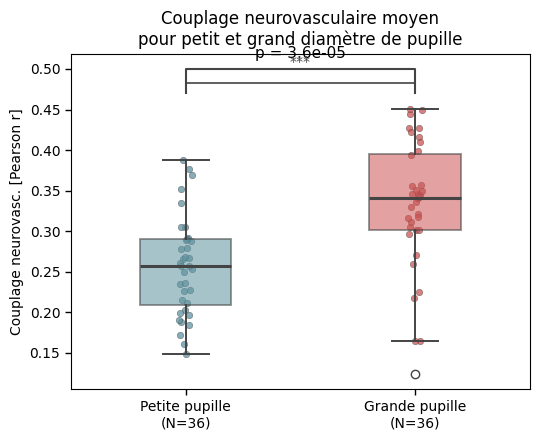

In [ ]:
import os
import pandas as pd

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
df = pd.read_csv(whole_file)

df = df[df["GCaMP"]]

n_low = df["nvc_segment_1/2"].values.shape[0]
n_high = df["nvc_segment_0/2"].values.shape[0]

fig, ax = boxplot_two_vectors_pretty(df["nvc_segment_1/2"], df["nvc_segment_0/2"], f"Petite pupille\n(N={n_low})", f"Grande pupille\n(N={n_high})", "Couplage neurovasc. [Pearson r]", title="Couplage neurovasculaire moyen\npour petit et grand diamètre de pupille", pvalue=False)

y, h, col = 0.47, 0.03, "#444444"

plt.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.savefig(f"{metric}_split_nvc_variation_coflucts2_wilcoxon.svg")
plt.show()

# 2. La variation du nvc diminue avec l'âge

In [35]:
import os
import pandas as pd

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
# whole_file = os.path.join(data_folder, f"nvc_region_Retrosplenial_left_{file_id}_df.csv")

df = pd.read_csv(whole_file)

age_map = {
    6: "Jeune (6-10 mois)",
    8: "Jeune (6-10 mois)",
    10: "Jeune (6-10 mois)",
    12: "Vieux (12-16 mois)",
    14: "Vieux (12-16 mois)",
    16: "Vieux (12-16 mois)"
}

df = df[df["GCaMP"]]
df["age_group"] = df["age"].map(age_map)
df["age_group"] = df["age_group"].astype(str).str.strip("'")

df["nvc_diff"] = df["nvc_segment_0/2"] - df["nvc_segment_1/2"]

n_jeune = df.loc[df["age_group"] == "Jeune (6-10 mois)", "nvc_diff"].values.shape[0]
n_vieux = df.loc[df["age_group"] == "Vieux (12-16 mois)", "nvc_diff"].values.shape[0]

id_jeune = df.loc[df["age_group"] == "Jeune (6-10 mois)", "id"].values
id_vieux = df.loc[df["age_group"] == "Vieux (12-16 mois)", "id"].values

id_jeune = np.asarray([(i.split("_")[0].split("M")[1]) for i in id_jeune])
id_vieux = np.asarray([(i.split("_")[0].split("M")[1]) for i in id_vieux])

print(id_jeune)
print(id_vieux)

seed = np.random.seed(1)
connect_pairs = True

if connect_pairs:
    save_str = "lines"
else:
    save_str = "nolines"

fig, ax = boxplot_two_vectors_pretty(df.loc[df["age_group"] == "Jeune (6-10 mois)", "nvc_diff"].values, df.loc[df["age_group"] == "Vieux (12-16 mois)", "nvc_diff"].values, f"Jeune\n(6-10 mois)\n(N={n_jeune})", f"Vieux\n(12-16 mois)\n(N={n_vieux})", "Variation [Pearson r]", title="Augmentation du couplage neurovasculaire\ndurant les hautes co-fluctuations neuronales", box_width=0.2, positions=[1, 1.6],
                                     pvalue=False, connect_pairs=connect_pairs, id1=id_jeune, id2=id_vieux)

ax.set_xlim(0.75, 1.85)
y, h, col = 0.32, 0.01, "#444444"

plt.plot([1, 1, 1.6, 1.6], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+1.6)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.savefig(f"{metric}_split_nvc_variation_w_age_{save_str}2.svg")
plt.show()

['316-8' '316-10' '322-6' '322-8' '322-10' '353-6' '353-8' '353-10'
 '361-6' '365-6' '367-6' '374-6' '374-8' '374-10' '387-6' '387-10' '396-6'
 '397-6' '410-6' '410-8' '410-10' '412-8' '412-10' '415-6' '415-8']
['316-12' '316-14' '316-16' '322-12' '322-14' '353-12' '353-14' '387-12'
 '410-12' '410-14' '412-12']


ValueError: The samples x and y must have the same length.

# 3. Le couplage neurovasculaire est plus élevé pour les souris GCaMP que WT

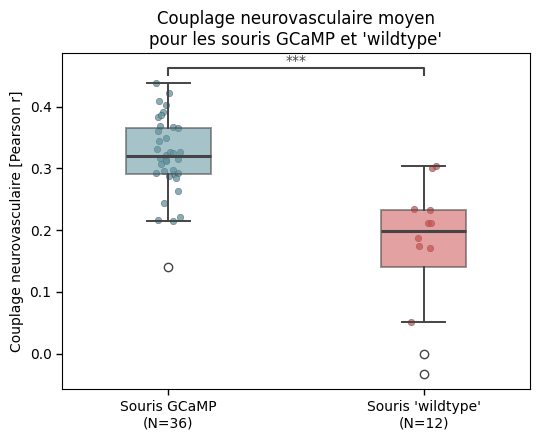

In [ ]:
import os
import pandas as pd

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
df = pd.read_csv(whole_file)



gc = df.loc[df["GCaMP"] == True, "nvc_whole"].values
wt = df.loc[df["GCaMP"] == False, "nvc_whole"].values

n_gc = gc.shape[0]
n_wt = wt.shape[0]

seed = np.random.seed(1)


fig, ax = boxplot_two_vectors_pretty(gc, wt, f"Souris GCaMP\n(N={n_gc})", f"Souris 'wildtype'\n(N={n_wt})", "Couplage neurovasculaire [Pearson r]", title="Couplage neurovasculaire moyen\npour les souris GCaMP et 'wildtype'", box_width=0.2, positions=[1, 1.6],
                                     connect_pairs=False, pvalue=False)

# ax.set_xlim(0.85, 1.75)
ax.set_xlim(0.75, 1.85)
# ax.set_ylim(-0.1, 0.5)
y, h, col = 0.452, 0.01, "#444444"

plt.plot([1, 1, 1.6, 1.6], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+1.6)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig(f"nvc_GCaMP_vs_WT2.svg")
plt.show()

p-value for ('Motor', 'Somatosensory') pair:
3.4824386921275383e-09


p-value for ('Motor', 'Retrosplenial') pair:
5.6668966114596886e-05


p-value for ('Motor', 'Visual') pair:
0.01722010111293361


p-value for ('Somatosensory', 'Retrosplenial') pair:
5.453312050528961e-13


p-value for ('Somatosensory', 'Visual') pair:
1.7456256105537734e-06


p-value for ('Retrosplenial', 'Visual') pair:
4.893334475848187e-09




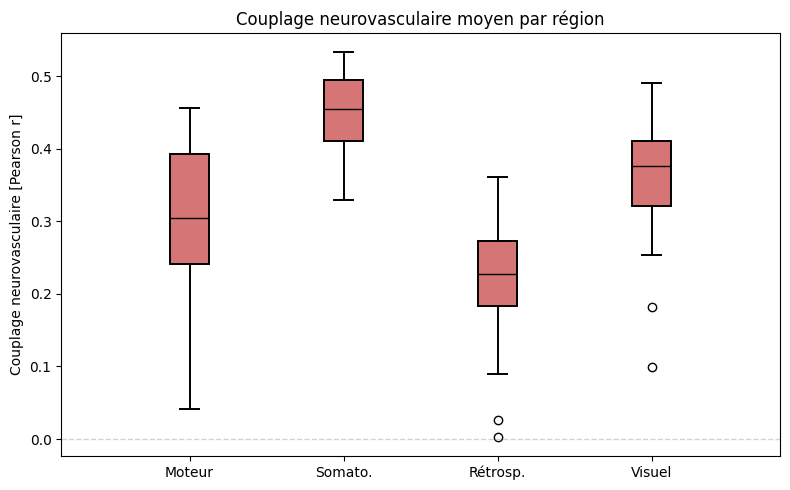

In [ ]:
params = dict(
        figsize=(8, 5),
        title="Couplage neurovasculaire moyen par région",
        ylabel="Couplage neurovasculaire [Pearson r]",

        # main data (usually 2: GCaMP False / True)
        main_colors=["#CC5555CF", "#CC5555"],
        main_labels=["GCaMP=False", "GCaMP=True"],
        box_width=0.15,

        # null model
        null_colors=["lightgrey", "darkgrey", "silver"],
        null_labels=["Null 1", "Null 2", "Null 3"],
        null_box_width=0.1,

        # position structure
        group_spacing=0.1,
        item_spacing=0.5,

        # options
        single_box=False,     # <---- NEW FEATURE: only show ONE box per group
        swarm=False,          # <---- NEW: jittered points on top
        jitter=0.08,
        jitter_outliers=False,  # <---- NEW: keep outliers centered on the boxplot outlier circles

        # p-values
        pval_indices=(0, 1),
        pval_fontsize=10,
        pval_offset=0.06,

        # axis
        y0_line=True,
        display_legend=False
    )

files = [os.path.join(data_folder, f"nvc_region_{region}_{file_id}_df.csv") for region in regions]
# null_filenames = [[os.path.join(data_folder, f"nvc_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]
null_filenames = None

# fig = plot_csv_groups(files, regions, column="nvc_whole", params=params, pval_func=pval_func, null_filenames=None, only_gcamp=False)
# plt.show()

fig, ax = plot_csv_groups(files, ["Moteur", "Somato.", "Rétrosp.", "Visuel"], column="nvc_whole", params=params, pval_func=pval_func, null_filenames=None, only_gcamp=True)

import itertools

for pair in itertools.combinations(regions, 2):
    if pair[0] == pair[1]:
        continue

    region1 = pair[0]
    region2 = pair[1]

    file1 = os.path.join(data_folder, f"nvc_region_{region1}_{file_id}_df.csv")
    file2 = os.path.join(data_folder, f"nvc_region_{region2}_{file_id}_df.csv")

    df1 = pd.read_csv(file1)
    df1 = df1[df1["GCaMP"]]

    df2 = pd.read_csv(file2)
    df2 = df2[df2["GCaMP"]]

    vec1 = df1["nvc_whole"].values
    vec2 = df2["nvc_whole"].values

    # pval = pval_func(vec1, vec2)
    pval = wilcoxon(vec1, vec2).pvalue

    print(f"p-value for {pair} pair:\n{pval}\n\n")




# ax.set_xlim(1, 20)
# ax.set_ylim(-0.1, 0.5)
# bars = [(1, 3, 0.5, 0.03, "#444444")] # (x1, x2, y, h, col)

# for bar in bars:
#     x1, x2, y, h, col = bar
#     plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig(f"PLACEHOLDER_region_nvc2.svg")
plt.show()
